## First Attempt of Shear Profile of A360 with metadetection

Contact author: Miranda Gorsuch

First attempt at creating a shear profile for A360 using cell-based coadds and `metadetection`. Many parts are from the [Shear profile around A360 using ComCam HSM shapes](https://github.com/lsst-sitcom/comcam_clusters/blob/main/ACO360_WL_HSCcalib_CLMM.ipynb) notebook, especially the identification of red sequence galaxies and use of CLMM to create the tangential shear plot.

Last working weekly: `w_2025_20`

Container Size: small (4 GB)

This is not a finished notebook and requires a lot of work yet. This is to show that the end-to-end for the generation of cell-based coadds, running `metadetection`, calibrating shears, and calculating tangential shears is almost in place.

Things to check / improve / fix
- [ ] Generate cell-based coadds in *g* and *z* bands
- [ ] Better identification and removal of RS galaxies
- [ ] Removal of duplicate objects from tract / patch overlap
- [ ] Compute shape errors from `metadetect`
- [ ] Check where factor of 2 is needed for e to g conversion (shapes should already be in g)
- [ ] Apply linear response calibration to radial bins of source galaxies
- [ ] Apply CLMM to binned information rather than all galaxies (or calculate tangential shear manually)

## Imports & Definitions

In [1]:
from lsst.daf.butler import Butler

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib

import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord

import gc

from lsst.skymap import Index2D
import lsst.afw.geom as afwGeom
import lsst.afw.math as afwMath
import lsst.geom as geom

%matplotlib inline

In [2]:
REPO = '/sdf/data/rubin/repo/main/'
butler = Butler(REPO)
registry = butler.registry

# collection = 'u/mgorsuch/metadetect/comcam_Rubin_SV_38_7/20250416T020244Z'
collection = 'u/mgorsuch/metadetect/a360/20250513T210342Z' # metadetect run on two bands
cell_collection = 'u/mgorsuch/a360_cell_coadd/20250513T044026Z' # cells used as input

## Prepare data

Metadetect outputs tables for each patch. Read in each table and compile them together.

In [3]:
# Position of the BCG for A360
ra_bcg = 37.862
dec_bcg = 6.98

The cell below is for finding the tracts/patches that are within the specified radius of the BCG. This is already incorporated in the butler collection used for the `metadetect` output.

In [4]:
# skymap = butler.get('skyMap', skymap='lsst_cells_v1', collections='LSSTComCam/runs/DRP/DP1/w_2025_06/DM-48810')

# # Looking for all patches in delta deg region around it
# delta = 0.5
# center = geom.SpherePoint(ra_bcg, dec_bcg, geom.degrees)
# ra_min, ra_max = ra_bcg - delta, ra_bcg + delta
# dec_min, dec_max = dec_bcg - delta, dec_bcg + delta

# ra_range = (ra_min, ra_max)
# dec_range = (dec_min, dec_max)
# radec = [geom.SpherePoint(ra_range[0], dec_range[0], geom.degrees),
#          geom.SpherePoint(ra_range[0], dec_range[1], geom.degrees),
#          geom.SpherePoint(ra_range[1], dec_range[0], geom.degrees),
#          geom.SpherePoint(ra_range[1], dec_range[1], geom.degrees)]

# tractPatchList = skymap.findTractPatchList(radec)

# find dataset refs that are within the tract/patch list above
# datasetRefs_shear = []
# datasetRefs_catalog = []

# for tractPatch in tractPatchList:
#     tract = tractPatch[0]
#     patchInfo = tractPatch[1]
#     for patch in patchInfo:
#         datasetRefs_shear.append(butler.query_datasets('ShearObject', 
#                                                  collections=collection,
#                                                  tract=tract.tract_id,
#                                                  patch=patch.sequential_index))
#         datasetRefs_catalog.append(butler.query_datasets('objectTable', 
#                                                  collections=default_collection,
#                                                  tract=tract.tract_id,
#                                                  patch=patch.sequential_index))

In [4]:
datasetRefs_shear = []

for ref in butler.registry.queryDatasets('ShearObject', collections=collection):
    datasetRefs_shear.append(butler.query_datasets('ShearObject', 
                                                 collections=collection,
                                                 skymap = 'lsst_cells_v1',
                                                 tract=ref.dataId['tract'],
                                                 patch=ref.dataId['patch']))

In [5]:
shear_table_list = []

for i, ref in enumerate(datasetRefs_shear):
    shear_data_patch = butler.get(ref[0])
    shear_table_patch = shear_data_patch.to_pandas()
    shear_table_list.append(shear_table_patch)

shear_table = pd.concat(shear_table_list)

# remove unused tables to clear up memory
del shear_table_list
gc.collect()

302

In [6]:
# remove overlapping rows due to patch overlap    
print("Number of rows prior to removing duplicates: ", len(shear_table))
shear_table= shear_table.drop_duplicates(subset=['shear_type', 'ra', 'dec']) # each object will potentially have several sheared images
print("Number of rows after removing duplicates: ", len(shear_table))

Number of rows prior to removing duplicates:  624643
Number of rows after removing duplicates:  618467


In [7]:
# make new columns to convert nJy fluxes to AB magnitudes
t1 = Table.from_pandas(shear_table)

t1['wmom_band_mag_r'] = (t1['wmom_band_flux_r']*u.nJy).to(u.ABmag)
t1['wmom_band_mag_i'] = (t1['wmom_band_flux_i']*u.nJy).to(u.ABmag)
t1['wmom_color_mag_r-i'] = t1['wmom_band_mag_r']-t1['wmom_band_mag_i']

shear_table = t1.to_pandas()

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


## Apply `metadetect` flags

Anything that is flagged should be removed.

In [12]:
print(shear_table['wmom_flags'].unique())
print(shear_table['psfrec_flags'].unique())
print(shear_table['wmom_psf_flags'].unique())
print(shear_table['wmom_obj_flags'].unique())
print(shear_table['wmom_T_flags'].unique())
print(shear_table['wmom_band_flux_flags_r'].unique())
print(shear_table['wmom_band_flux_flags_i'].unique())

[       0  1048576  2097156 33554432]
[0]
[ 0  1 64]
[      0       1 2097156]
[0 1 4]
[0 1]
[0 1]


In [8]:
meta_filter = shear_table['wmom_flags']==False
meta_filter &= shear_table['psfrec_flags']==False
meta_filter &= shear_table['wmom_psf_flags']==False
meta_filter &= shear_table['wmom_obj_flags']==False
meta_filter &= shear_table['wmom_T_flags']==False
meta_filter &= shear_table['wmom_band_flux_flags_r']==False
meta_filter &= shear_table['wmom_band_flux_flags_i']==False

shear_table = shear_table[meta_filter]

print("Number of rows after removing metadetect flags: ", len(shear_table))

Number of rows after removing metadetect flags:  505013


## Quality cuts

Using cuts from [Yamamoto 2024](https://arxiv.org/abs/2501.05665) for
- Star/galaxy separation
- S/N
- Size (visually check first if needed)
- Flux
- Color

These may need to be updated provided this is a different dataset, but should be a good starting point.

(It looks like the metadetect flags applied already take these into account?)

In [14]:
print("Object size ratio rows removed: ", len(shear_table)-len(shear_table[shear_table['wmom_T_ratio']>0.5]))
print("S/N ratio rows removed: ", len(shear_table)-len(shear_table[shear_table['wmom_s2n']>10]))
print("Size rows removed: ", len(shear_table)-len(shear_table[shear_table['wmom_T']<20]))
print("m_frac rows removed: ", len(shear_table)-len(shear_table[shear_table['mfrac']<0.1]))
print("faint in r-band removed: ", len(shear_table)-len(shear_table[shear_table['wmom_band_mag_r']<26.5]))
print("faint in i-band removed: ", len(shear_table)-len(shear_table[shear_table['wmom_band_mag_i']<24.7]))
print("r-i flux rows removed: ", 
      len(shear_table)-len(shear_table[(shear_table['wmom_band_mag_r']-shear_table['wmom_band_mag_i']).abs()<5]))

Object size ratio rows removed:  1
S/N ratio rows removed:  0
Size rows removed:  0
m_frac rows removed:  0
faint in r-band removed:  190
faint in i-band removed:  346
r-i flux rows removed:  246


In [9]:
q_cuts = shear_table['wmom_T_ratio']>0.5
q_cuts &= shear_table['wmom_s2n']>10
q_cuts &= shear_table['wmom_T']<20
q_cuts &= shear_table['mfrac']<20
q_cuts &= shear_table['wmom_band_mag_r']<26.5
q_cuts &= shear_table['wmom_band_mag_i']<24.7
q_cuts &= (shear_table['wmom_band_mag_r']-shear_table['wmom_band_mag_i']).abs()<5

shear_table = shear_table[q_cuts]

print("Number of rows after applying quality cuts: ", len(shear_table))

Number of rows after applying quality cuts:  504465


## Check shear types for each object

Each object is detected and measured separately for each sheared/unsheared image. The catalogs will not necessarily be the same but should be close in number of objects.

In [13]:
print("Number of shear type 'ns': ", len(shear_table[shear_table['shear_type']=='ns']))
print("Number of shear type '1p': ", len(shear_table[shear_table['shear_type']=='1p']))
print("Number of shear type '1m': ", len(shear_table[shear_table['shear_type']=='1m']))
print("Number of shear type '2p': ", len(shear_table[shear_table['shear_type']=='2p']))
print("Number of shear type '2m': ", len(shear_table[shear_table['shear_type']=='2m']))

Number of shear type 'ns':  100858
Number of shear type '1p':  100943
Number of shear type '1m':  100794
Number of shear type '2p':  100955
Number of shear type '2m':  100915


## Check g1/g2 and PSF ellipticities

Check that the PSF and object ellipticities average to ~0

In [13]:
# print mean values
print("Mean of psfrec_g_1: ", shear_table['psfrec_g_1'].median())
print("Mean of psfrec_g_2: ", shear_table['psfrec_g_2'].median())
print("Mean of wmom_g_1: ", shear_table['wmom_g_1'].median())
print("Mean of wmom_g_2: ", shear_table['wmom_g_2'].median())

Mean of psfrec_g_1:  -0.04148779436945915
Mean of psfrec_g_2:  0.0020895516499876976
Mean of wmom_g_1:  -0.00021677161566913128
Mean of wmom_g_2:  -0.00016584640252403915


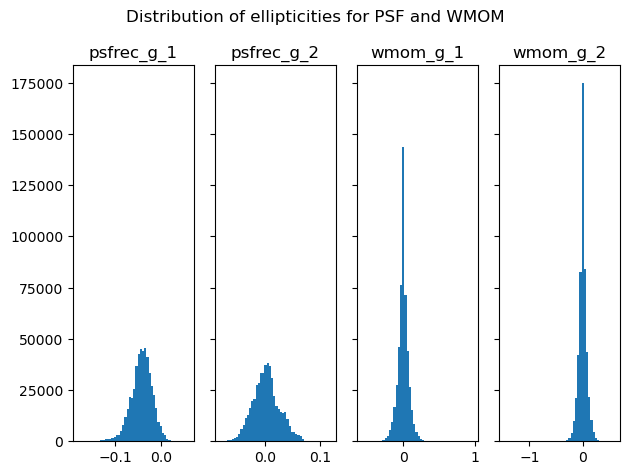

In [14]:
n_bins = 50

fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True)

axs[0].hist(shear_table['psfrec_g_1'], bins=n_bins)
axs[0].set_title('psfrec_g_1')
axs[1].hist(shear_table['psfrec_g_2'], bins=n_bins)
axs[1].set_title('psfrec_g_2')
axs[2].hist(shear_table['wmom_g_1'], bins=n_bins)
axs[2].set_title('wmom_g_1')
axs[3].hist(shear_table['wmom_g_2'], bins=n_bins)
axs[3].set_title('wmom_g_2')

fig.suptitle("Distribution of ellipticities for PSF and WMOM")

plt.show()

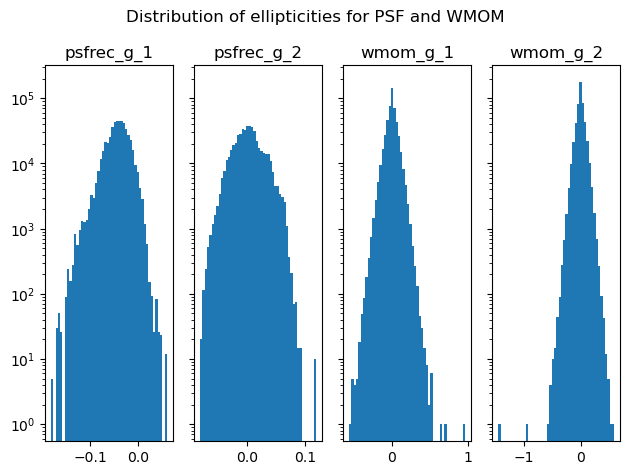

In [15]:
n_bins = 50

fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True)

axs[0].hist(shear_table['psfrec_g_1'], bins=n_bins)
axs[0].set_yscale('log')
axs[0].set_title('psfrec_g_1')
axs[1].hist(shear_table['psfrec_g_2'], bins=n_bins)
axs[1].set_title('psfrec_g_2')
axs[1].set_yscale('log')
axs[2].hist(shear_table['wmom_g_1'], bins=n_bins)
axs[2].set_title('wmom_g_1')
axs[2].set_yscale('log')
axs[3].hist(shear_table['wmom_g_2'], bins=n_bins)
axs[3].set_title('wmom_g_2')
axs[3].set_yscale('log')

fig.suptitle("Distribution of ellipticities for PSF and WMOM")

plt.show()

PSG g1 appears less biased than last time, though is still pretty obiously biased. (Previously, 1 band with 4 whole tracts, had -0.25.)

## Identify and remove cluster member galaxies

### Filter objects to within < 0.1 deg of cluster center

In [10]:
c1 = SkyCoord(shear_table['ra'].values*u.deg, shear_table['dec'].values*u.deg)
c2 = SkyCoord(ra_bcg*u.deg, dec_bcg*u.deg)
sep = c1.separation(c2)

sep.deg
filt = sep.deg < 0.1 # stay close to cluster center for RS indentification
# filt &= shear_table['shear_type']=='ns' # look at just the non-sheared objects
shear_table_rs = shear_table[filt] # catalog for RS identification
print("Number of rows after applying < 0.1 deg from center: ", len(shear_table_rs))

Number of rows after applying < 0.1 deg from center:  10647


### Color-magnitude diagram

Identify red sequence by eye for now.

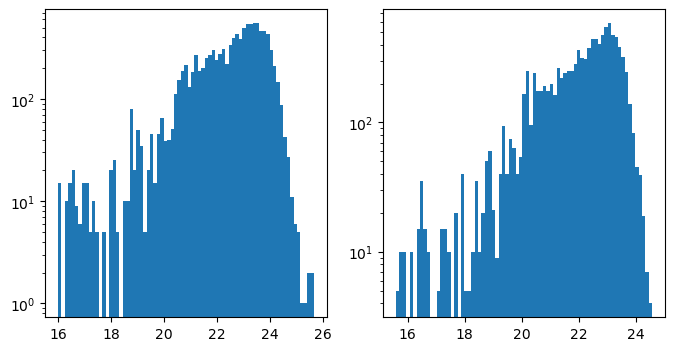

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
ax[0].hist(shear_table_rs['wmom_band_mag_r'], bins=75)
ax[1].hist(shear_table_rs['wmom_band_mag_i'], bins=75)
ax[0].set_yscale('log')
ax[1].set_yscale('log')

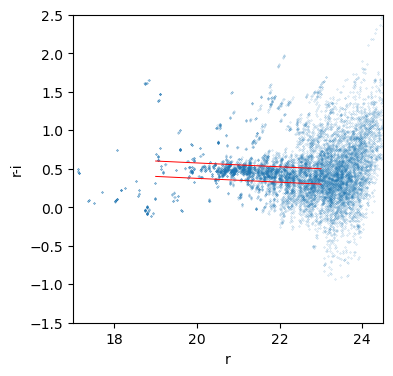

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, 
                         figsize=(4,4))
ax.scatter(shear_table_rs['wmom_band_mag_r'], shear_table_rs['wmom_band_mag_r']-shear_table_rs['wmom_band_mag_i'], 
           marker='.', s=0.2, alpha=0.5)
ax.set_ylim([-1.5,2.5])
ax.set_xlim([17,24.5])
ax.set_ylabel('r-i')
ax.set_xlabel('r')
ax.plot([19,23],[0.4,0.3], color='r', linewidth=0.7)
ax.plot([19,23],[0.6,0.5], color='r', linewidth=0.7)

Note that the "smeary" look is due to the 5 sheared/unsheared images of the same object that are detected & measured in slightly different ways.

### Filter RS galaxies

In [12]:
rs_hi = 0.6 - (0.1/5.) * (shear_table_rs['wmom_band_mag_r']-19)
rs_low = 0.4 - (0.1/5.)* (shear_table_rs['wmom_band_mag_r']-19)
color = shear_table_rs['wmom_band_mag_r'] - shear_table_rs['wmom_band_mag_i']

idx = np.where(np.logical_and(color>rs_low, color<rs_hi))[0]
idx2 = np.where(shear_table_rs['wmom_band_mag_r'].iloc[idx] < 23)[0] # keep the brightest objects only

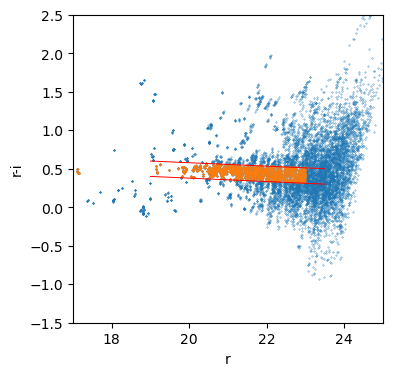

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, 
                         figsize=(4,4))
ax.scatter(shear_table_rs['wmom_band_mag_r'], shear_table_rs['wmom_band_mag_r']-shear_table_rs['wmom_band_mag_i'], 
           marker='.', s=0.3) # all galaxies  
ax.scatter(shear_table_rs['wmom_band_mag_r'].iloc[idx].iloc[idx2], 
           shear_table_rs['wmom_band_mag_r'].iloc[idx].iloc[idx2]-shear_table_rs['wmom_band_mag_i'].iloc[idx].iloc[idx2], 
           marker='.', s=0.3) #red sequence galaxies
ax.set_ylim([-1.5,2.5])
ax.set_xlim([17,25])
ax.set_ylabel('r-i')
ax.set_xlabel('r')
ax.plot([19,23.5],[0.4,0.3], color='r', linewidth=0.7)
ax.plot([19,23.5],[0.6,0.5], color='r', linewidth=0.7)

Cut out the RS galaxies identified above.

In [14]:
filt = sep.deg < 0.5 # larger field for analysis
# filt &= shear_table['shear_type']=='ns' # look at just the non-sheared objects
shear_table_wl = shear_table[filt]

In [15]:
# Filter defined above applied to the full sample
rs_hi = 0.6 - (0.1/5.) * (shear_table_wl['wmom_band_mag_r']-19)
rs_low = 0.4 - (0.1/5.)* (shear_table_wl['wmom_band_mag_r']-19)
color = shear_table_wl['wmom_band_mag_r'] - shear_table_wl['wmom_band_mag_i']

# Filter defined above applied to the full sample
rs_hi = 0.6 - (0.1/5.) * (shear_table_wl['wmom_band_mag_r']-19)
rs_low = 0.4 - (0.1/5.)* (shear_table_wl['wmom_band_mag_r']-19)

idx = np.where(np.logical_and(color>rs_low, color<rs_hi))[0]
idx2 = np.where(shear_table_wl['wmom_band_mag_r'].iloc[idx] < 23)[0] # keep the brightest objects only

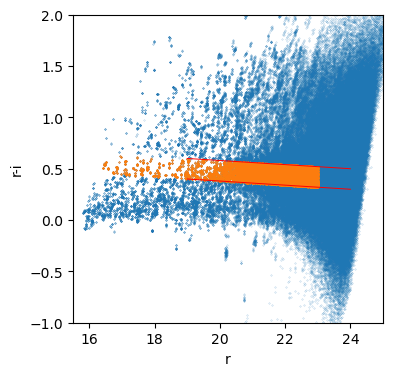

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, 
                         figsize=(4,4))
ax.scatter(shear_table_wl['wmom_band_mag_r'], shear_table_wl['wmom_band_mag_r']-shear_table_wl['wmom_band_mag_i'],
            marker='.', s=0.2, alpha=0.5) # all galaxies  
ax.scatter(shear_table_wl['wmom_band_mag_r'].iloc[idx].iloc[idx2], 
           shear_table_wl['wmom_band_mag_r'].iloc[idx].iloc[idx2]-shear_table_wl['wmom_band_mag_i'].iloc[idx].iloc[idx2], 
           marker='.', s=0.2) #red sequence galaxies
ax.set_ylim([-1,2])
ax.set_xlim([15.5,25])
ax.set_ylabel('r-i')
ax.set_xlabel('r')
ax.plot([19,24],[0.4,0.3], color='r', linewidth=0.7)
ax.plot([19,24],[0.6,0.5], color='r', linewidth=0.7)

In [22]:
RS_id_list = shear_table_wl['id'].iloc[idx].iloc[idx2]

In [23]:
len(RS_id_list)

31688

In [24]:
# Filter out rows where the 'dataid' column matches any value in RS_id_list
shear_table_wl = shear_table_wl[~shear_table_wl['id'].isin(RS_id_list)]

In [25]:
len(shear_table_wl)

16899

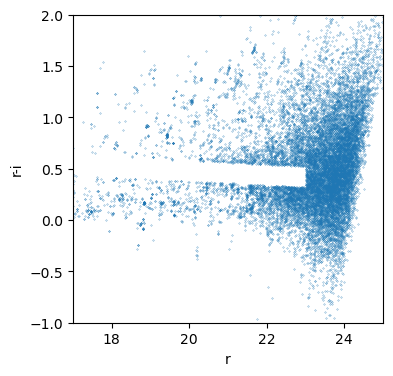

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(4,4))
ax.scatter(shear_table_wl['wmom_band_mag_r'], shear_table_wl['wmom_color_mag_r-i'], 
           marker='.', s=0.2) # all galaxies  
ax.set_ylim([-1,2])
ax.set_xlim([17,25])
ax.set_ylabel('r-i')
ax.set_xlabel('r')
plt.show()

In [27]:
ra = shear_table_wl['ra']
dec = shear_table_wl['dec']
e1 = shear_table_wl['wmom_g_1']
e2 = shear_table_wl['wmom_g_2']
# e_err = shear_table_wl['i_hsmShapeRegauss_sigma']

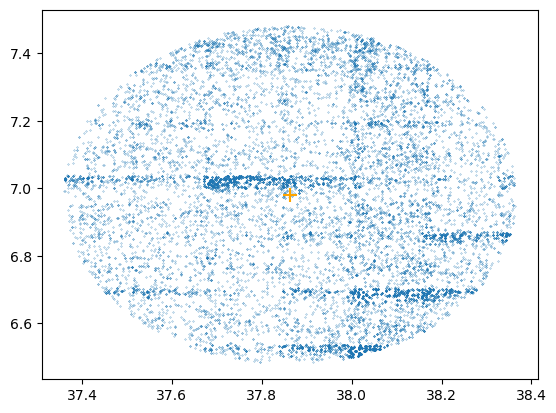

In [29]:
plt.scatter(ra, dec, marker='.', s=0.2)
plt.scatter([ra_bcg], [dec_bcg], marker='+', s=100, color='orange')

### Check lines of overdensity

Lines of overdensity: imperfect overlap of objects between patches/tracts.

In [33]:
patch_list = []

for ref in butler.registry.queryDatasets('deepCoaddCell', collections=cell_collection, band='i'):
    patch_list.append(butler.query_datasets('deepCoaddCell', 
                                                 collections=cell_collection,
                                                 skymap = 'lsst_cells_v1',
                                                 band = 'i',
                                                 tract=ref.dataId['tract'],
                                                 patch=ref.dataId['patch'])[0])

In [44]:
segs = []

for ref in patch_list:
    
    coadd = butler.get('deepCoaddCell',
                      collections=cell_collection,
                      skymap = 'lsst_cells_v1',
                      band = 'i',
                      tract=ref.dataId['tract'],
                      patch=ref.dataId['patch'])

    wcs = coadd.wcs
    bbox = coadd.inner_bbox

    coadd_corners = coadd.inner_bbox.getCorners()

    for index, corner in enumerate(coadd_corners):
        corner_coord_start = wcs.pixelToSky(corner.getX(), corner.getY())
        if index < 3:
            corner_coord_end = wcs.pixelToSky(coadd_corners[index+1].getX(), coadd_corners[index+1].getY())
        else:
            corner_coord_end = wcs.pixelToSky(coadd_corners[0].getX(), coadd_corners[0].getY())
    
        start_ra = corner_coord_start[0].asDegrees()
        start_dec = corner_coord_start[1].asDegrees()
    
        end_ra = corner_coord_end[0].asDegrees()
        end_dec = corner_coord_end[1].asDegrees()

        segs.append(((start_ra, start_dec), (end_ra, end_dec)))

    del coadd
    gc.collect()

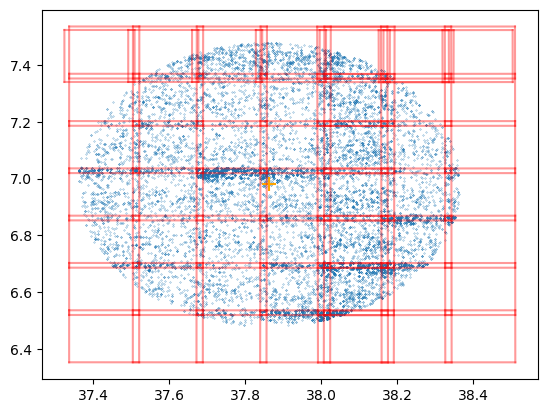

In [49]:
plt.scatter(ra, dec, marker='.', s=0.2)
plt.scatter([ra_bcg], [dec_bcg], marker='+', s=100, color='orange')
for seg in segs:
    plt.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.4)
plt.show()

## Apply linear shear response calibration

In [28]:
from numpy.linalg import inv

In [29]:
shear_diff = 0.02

p1_mean = shear_table_wl[shear_table_wl['shear_type']=='1p']['wmom_g_1'].mean()
m1_mean = shear_table_wl[shear_table_wl['shear_type']=='1m']['wmom_g_1'].mean()
p2_mean = shear_table_wl[shear_table_wl['shear_type']=='2p']['wmom_g_2'].mean()
m2_mean = shear_table_wl[shear_table_wl['shear_type']=='2m']['wmom_g_2'].mean()

In [30]:
r_matrix = [[0, 0],[0, 0]]

r_matrix[0][0] = (p1_mean - m1_mean) / shear_diff # this should be right
# r_matrix[0][1] = (p2_mean - m2_mean) / shear_diff # ignore?
# r_matrix[1][0] = (p1_mean - m1_mean) / shear_diff # ignore?
r_matrix[1][1] = (p2_mean - m2_mean) / shear_diff # and this should be right

In [31]:
r_matrix_inv = inv(r_matrix)

### Global shear estimate

In [105]:
gs = [shear_table_wl[shear_table_wl['shear_type']=='ns']['wmom_g_1'].mean(),
      shear_table_wl[shear_table_wl['shear_type']=='ns']['wmom_g_2'].mean()]

In [106]:
gs

[-0.0009405334, 0.000991326]

In [107]:
gammas = r_matrix_inv.dot(gs) / 2.

In [108]:
gammas

array([-0.00233052,  0.005326  ])

### Calibrate data by radial bins

For now, estimate all bins with the same R

In [61]:
shear_table_ns = shear_table_wl[shear_table_wl['shear_type']=='ns']

In [36]:
# angular_bins = [0.1, 0.2, 0.3, 0.4, 0.5] # in degrees, for now

In [49]:
# Radial binning, either in Mpc or degrees
bins_mpc = clmm.make_bins(0.7,5,nbins=5, method='evenlog10width')
bins_deg = clmm.make_bins(0.1,0.5,nbins=5, method='evenlog10width')

In [53]:
bins_deg

array([0.1       , 0.13797297, 0.19036539, 0.26265278, 0.36238983,
       0.5       ])

In [63]:
c1 = SkyCoord(shear_table_ns['ra'].values*u.deg, shear_table_ns['dec'].values*u.deg)
c2 = SkyCoord(ra_bcg*u.deg, dec_bcg*u.deg)
sep = c1.separation(c2)
sep.deg

filt1 = sep.deg < bins_deg[0]
shear_table_ns_bin1 = shear_table_ns[filt1]

filt2 = sep.deg >= bins_deg[0]
filt2 &= sep.deg < bins_deg[1]
shear_table_ns_bin2 = shear_table_ns[filt2]

filt3 = sep.deg >= bins_deg[1]
filt3 &= sep.deg < bins_deg[2]
shear_table_ns_bin3 = shear_table_ns[filt3]

filt4 = sep.deg >= bins_deg[2]
filt4 &= sep.deg < bins_deg[3]
shear_table_ns_bin4 = shear_table_ns[filt4]

filt5 = sep.deg >= bins_deg[3]
filt5 &= sep.deg < bins_deg[4]
shear_table_ns_bin5 = shear_table_ns[filt5]

print("Number of rows for bin 1: ", len(shear_table_ns_bin1))
print("Number of rows for bin 2: ", len(shear_table_ns_bin2))
print("Number of rows for bin 3: ", len(shear_table_ns_bin3))
print("Number of rows for bin 4: ", len(shear_table_ns_bin4))
print("Number of rows for bin 5: ", len(shear_table_ns_bin5))

Number of rows for bin 1:  224
Number of rows for bin 2:  132
Number of rows for bin 3:  256
Number of rows for bin 4:  310
Number of rows for bin 5:  678


In [75]:
gs = [[shear_table_ns_bin1['wmom_g_1'].mean(), shear_table_ns_bin1['wmom_g_2'].mean()],
      [shear_table_ns_bin2['wmom_g_1'].mean(), shear_table_ns_bin2['wmom_g_2'].mean()],
      [shear_table_ns_bin3['wmom_g_1'].mean(), shear_table_ns_bin3['wmom_g_2'].mean()],
      [shear_table_ns_bin4['wmom_g_1'].mean(), shear_table_ns_bin4['wmom_g_2'].mean()],
      [shear_table_ns_bin5['wmom_g_1'].mean(), shear_table_ns_bin5['wmom_g_2'].mean()]]

gammas = [r_matrix_inv.dot(gs[i]) for i in range(5)]

In [72]:
ra_list = [(ra_bcg + bins_deg[i]) for i in range(len(bins_deg)-1)]
dec_list = [(dec_bcg + bins_deg[i]) for i in range(len(bins_deg)-1)]

In [40]:
gammas1

array([-0.01052166, -0.08949666])

In [41]:
gammas1_abs = np.sqrt(gammas1[0]**2 + gammas1[1]**2)
gammas2_abs = np.sqrt(gammas2[0]**2 + gammas2[1]**2)
gammas3_abs = np.sqrt(gammas3[0]**2 + gammas3[1]**2)
gammas4_abs = np.sqrt(gammas4[0]**2 + gammas4[1]**2)
gammas5_abs = np.sqrt(gammas5[0]**2 + gammas5[1]**2)

gammas = [gammas1_abs, gammas2_abs, gammas3_abs, gammas4_abs, gammas5_abs]

## Measure tangential shear as a function of radial distance

In [2]:
# locally install modeling packages
# pip install pyccl
# pip install clmm

In [34]:
import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData, Cosmology
from clmm import Cosmology, utils

cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

In [35]:
cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

In [79]:
gammas[:][0]

array([-0.01052166, -0.08949666])

In [97]:
galcat = GCData()
galcat['ra'] = shear_table_ns['ra']
galcat['dec'] = shear_table_ns['dec']
# galcat['e1'] = e1
# galcat['e2'] = e2
galcat['e1'] = shear_table_ns['wmom_g_1']
galcat['e2'] = shear_table_ns['wmom_g_2']
# galcat['e_err'] = e_err/2.  # factor 2 to account for conversion between e and g

galcat['z'] = np.zeros(len(shear_table_ns)) # CLMM needs a redshift column for the source, even if not used

In [98]:
cluster_id = "Abell 360"
gc_object1 = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat, coordinate_system='euclidean')

In [99]:
gc_object1.compute_tangential_and_cross_components(add=True)

(array([0.00870001, 0.00852436, 0.00870911, ..., 0.00497769, 0.00495465,
        0.00485412]),
 array([ 0.00274545,  0.0048383 ,  0.00549399, ..., -0.02222406,
         0.13768537, -0.02373351]),
 array([-0.00286663, -0.01800108,  0.00551508, ...,  0.10486896,
        -0.07013213,  0.00855043]))

In [100]:
# gc_object1.compute_galaxy_weights(
#         shape_component1="e1",
#         shape_component2="e2",
#         use_shape_error=True,
#         shape_component1_err="e_err",
#         shape_component2_err="e_err",
#         use_shape_noise=True,
#         weight_name="w_ls",
#         cosmo=cosmo,
#         add=True,
#     ) 

# TO-DO compute shape errors from metadetect
gc_object1.compute_galaxy_weights(
        shape_component1="e1",
        shape_component2="e2",
        use_shape_error=False,
        use_shape_noise=True,
        weight_name="w_ls",
        cosmo=cosmo,
        add=True,
    )

90.23355069377172

In [101]:
# Radial binning, either in Mpc or degrees
bins_mpc = clmm.make_bins(0.7,5,nbins=5, method='evenlog10width')
bins_deg = clmm.make_bins(0.1,0.5,nbins=5, method='evenlog10width')

In [102]:
gc_object1.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo, overwrite=True, use_weights=True);
# gc_object1.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo, overwrite=True, use_weights=False);

In [45]:
# Check the profile table
gc_object1.profile

radius_min,radius,radius_max,gt,gt_err,gx,gx_err,z,z_err,n_src,W_l
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
0.7,0.8441765334805479,1.0372237030430085,0.002833697592478983,0.006313933315792023,0.0018723436156545161,0.007791478483116093,0.0,0.0,77,6947.983403420416
1.0372237030430085,1.287675506868728,1.5369043002203584,-5.252942861769171e-05,0.0062374390918641396,0.00897060629004372,0.006745730573334324,0.0,0.0,113,10196.391228396213
1.5369043002203584,1.9234926804001633,2.277305099281834,0.002045774210092099,0.00426362400960631,0.0053439960549084885,0.004218648698096781,0.0,0.0,270,24363.05868731833
2.277305099281834,2.8371415309552597,3.374392611479757,-0.0015482967848008701,0.0037238595139179958,0.0003253978112674428,0.0038753087380620195,0.0,0.0,376,33927.81506085807
3.374392611479757,4.287464910153419,5.000000000000001,0.003071512105040711,0.0024842602213937513,0.0007406453688827336,0.0024982865179033055,0.0,0.0,939,84729.30410145146


In [103]:
moo = clmm.Modeling(massdef="mean", delta_mdef=200, halo_profile_model="nfw")

moo.set_cosmo(cosmo)
moo.set_concentration(4)
moo.set_mass(1.0e15)

z_cl = gc_object1.z

# source properties
# assume sources redshift following a the DESC SRD distribution. This will need updating.

z_distrib_func = utils.redshift_distributions.desc_srd  

# Compute first beta (e.g. eq(6) of WtGIII paper)
beta_kwargs = {
    "z_cl": z_cl,
    "z_inf": 10.0,
    "cosmo": cosmo,
    "z_distrib_func": z_distrib_func,
}
beta_s_mean = utils.compute_beta_s_mean_from_distribution(**beta_kwargs)
beta_s_square_mean = utils.compute_beta_s_square_mean_from_distribution(**beta_kwargs)

rproj = np.logspace(np.log10(0.3),np.log10(7.), 100)

gt_z = moo.eval_reduced_tangential_shear(
    rproj, z_cl, [beta_s_mean, beta_s_square_mean], z_src_info="beta", approx="order2"
)

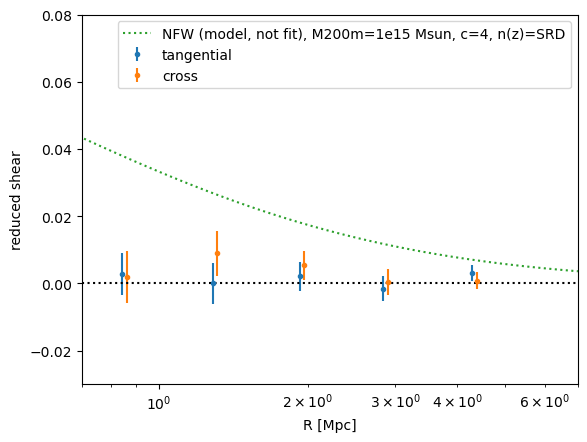

In [104]:
plt.errorbar(gc_object1.profile['radius'], gc_object1.profile['gt'], gc_object1.profile['gt_err'], 
             ls='', marker='.', label='tangential')
plt.errorbar(gc_object1.profile['radius']*1.02, gc_object1.profile['gx'], gc_object1.profile['gx_err'], 
             ls='', marker='.', label='cross')
plt.plot(rproj, gt_z, label='NFW (model, not fit), M200m=1e15 Msun, c=4, n(z)=SRD', ls=':')

plt.xscale('log')
plt.axhline(0.0, color='k', ls=':')
plt.ylim([-0.03,0.08])
plt.xlim([0.7,7])
#plt.yscale('log')
plt.xlabel('R [Mpc]')
plt.ylabel('reduced shear')
plt.legend(loc=1)